# **AI TECH INSTITUTE** · *Intermediate AI & Data Science*
### Week 01 · Notebook 03 — Data Wrangling & Transformation
**Instructor:** Amir Charkhi  |  **Goal:** Master real-world data manipulation techniques.

> Format: practical scenarios → powerful pandas methods → data ready for analysis.


---
## Real Data is Messy!
Let's load and clean actual messy data - the skills you'll use every day.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set display options for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

print("Ready to wrangle! 🛠️")

Ready to wrangle! 🛠️


## 1. Reading Data from Files

In [2]:
# Create sample CSV data (simulating a file)
csv_data = """order_id,customer_name,product,quantity,price,order_date
1001,Alice Smith,Laptop,1,1200.00,2025-08-15
1002,Bob Jones,Mouse,2,25.50,2025-08-15
1003,Charlie Brown,,1,80.00,2025-08-16
1004,Alice Smith,Monitor,1,,2025-08-16
1005,Diana Prince,Keyboard,3,75.00,2025-08-17
1006,,Webcam,1,120.00,2025-08-17
1007,Bob Jones,Laptop,1,1200,2025-08-18"""

# Save to file and read back
with open('orders.csv', 'w') as f:
    f.write(csv_data)

# Read CSV with proper data types
orders_df = pd.read_csv('orders.csv', parse_dates=['order_date'])
print("Raw data from CSV:")
print(orders_df)
print(f"\nData types:")
print(orders_df.dtypes)
print(f"\nMissing values:")
print(orders_df.isnull().sum())

Raw data from CSV:
   order_id  customer_name   product  quantity   price order_date
0      1001    Alice Smith    Laptop         1  1200.0 2025-08-15
1      1002      Bob Jones     Mouse         2    25.5 2025-08-15
2      1003  Charlie Brown       NaN         1    80.0 2025-08-16
3      1004    Alice Smith   Monitor         1     NaN 2025-08-16
4      1005   Diana Prince  Keyboard         3    75.0 2025-08-17
5      1006            NaN    Webcam         1   120.0 2025-08-17
6      1007      Bob Jones    Laptop         1  1200.0 2025-08-18

Data types:
order_id                  int64
customer_name            object
product                  object
quantity                  int64
price                   float64
order_date       datetime64[ns]
dtype: object

Missing values:
order_id         0
customer_name    1
product          1
quantity         0
price            1
order_date       0
dtype: int64


In [3]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       7 non-null      int64         
 1   customer_name  6 non-null      object        
 2   product        6 non-null      object        
 3   quantity       7 non-null      int64         
 4   price          6 non-null      float64       
 5   order_date     7 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 468.0+ bytes


## 2. Cleaning Missing and Incorrect Data

In [4]:
# Make a copy for cleaning
clean_df = orders_df.copy()

# Handle missing customer names
clean_df['customer_name'].fillna('Unknown Customer', inplace=True)

# Handle missing products (look at other orders from same customer)
clean_df.loc[2, 'product'] = 'Keyboard'  # Reasonable guess based on price

# Handle missing prices (use average for that product)
monitor_avg_price = 350.00  # Domain knowledge
clean_df.loc[3, 'price'] = monitor_avg_price

# Ensure price is float
clean_df['price'] = pd.to_numeric(clean_df['price'], errors='coerce')

# Calculate total
clean_df['total'] = clean_df['quantity'] * clean_df['price']

print("Cleaned data:")
print(clean_df)
print(f"\nRevenue by customer:")
print(clean_df.groupby('customer_name')['total'].sum().sort_values(ascending=False))

Cleaned data:
   order_id     customer_name   product  quantity   price order_date   total
0      1001       Alice Smith    Laptop         1  1200.0 2025-08-15  1200.0
1      1002         Bob Jones     Mouse         2    25.5 2025-08-15    51.0
2      1003     Charlie Brown  Keyboard         1    80.0 2025-08-16    80.0
3      1004       Alice Smith   Monitor         1   350.0 2025-08-16   350.0
4      1005      Diana Prince  Keyboard         3    75.0 2025-08-17   225.0
5      1006  Unknown Customer    Webcam         1   120.0 2025-08-17   120.0
6      1007         Bob Jones    Laptop         1  1200.0 2025-08-18  1200.0

Revenue by customer:
customer_name
Alice Smith         1550.0
Bob Jones           1251.0
Diana Prince         225.0
Unknown Customer     120.0
Charlie Brown         80.0
Name: total, dtype: float64


C:\Users\Olivia\AppData\Local\Temp\ipykernel_34068\2590105866.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df['customer_name'].fillna('Unknown Customer', inplace=True)


### Exercise 1 — Data Quality Check (medium)

**Exercise 1 — Data Quality Check (medium)**  
Create a function that returns a data quality report: % complete, unique counts, and outliers.


In [36]:
# test manual workflow before creating function

report = {}
report['completeness']=(1-orders_df.isnull().sum()/len(orders_df))*100
report['orders_df']=orders_df.nunique()
numeric_columns = orders_df.select_dtypes(include=[np.number]).columns

outliers = {}
for column in numeric_columns:
    Q1 = orders_df[column].quantile(0.25)
    Q3 = orders_df[column].quantile(0.75)
    IQR = Q3 - Q1
    low_outlier = Q1 -1.5*IQR
    high_outlier = Q3 + 1.5*IQR
    outliers[column] = ((orders_df[column]<low_outlier) | (orders_df[column]>high_outlier)).sum()
report['outliers']=pd.Series(outliers).astype(int)

In [38]:
# Your turn
def data_quality_report(df):
    report = {}
    report['completeness']=(1-df.isnull().sum()/len(df))*100
    report['unique_counts']=df.nunique()
    
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    outliers={}
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        low_outlier = Q1 -1.5*IQR
        high_outlier = Q3 + 1.5*IQR
        outliers[column] = ((df[column]<low_outlier) | (df[column]>high_outlier)).sum()
    report['outliers']=pd.Series(outliers).astype(int)
    return report

In [39]:
quality_report = data_quality_report(orders_df)
print("Data Quality Report:")
for key, value in quality_report.items():
    print(f"\n{key}:")
    print(value)

Data Quality Report:

completeness:
order_id         100.000000
customer_name     85.714286
product           85.714286
quantity         100.000000
price             85.714286
order_date       100.000000
dtype: float64

unique_counts:
order_id         7
customer_name    4
product          5
quantity         3
price            5
order_date       4
dtype: int64

outliers:
order_id    0
quantity    1
price       0
dtype: int64


<details>
<summary><b>Solution</b></summary>

```python
def data_quality_report(df):
    report = {}
    
    # Completeness
    report['completeness'] = (1 - df.isnull().sum() / len(df)) * 100
    
    # Unique counts
    report['unique_counts'] = df.nunique()
    
    # Outliers for numeric columns (using IQR)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    outliers = {}
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers[col] = ((df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)).sum()
    report['outliers'] = outliers
    
    return report

quality_report = data_quality_report(clean_df)
print("Data Quality Report:")
for key, value in quality_report.items():
    print(f"\n{key}:")
    print(value)
```
</details>

## 3. Merging and Joining DataFrames

In [40]:
# Create related dataframes
customers = pd.DataFrame({
    'customer_id': [1, 2, 3, 4],
    'name': ['Alice Smith', 'Bob Jones', 'Charlie Brown', 'Diana Prince'],
    'city': ['Perth', 'Sydney', 'Melbourne', 'Brisbane'],
    'member_since': ['2023-01-15', '2023-06-20', '2024-02-10', '2024-08-01']
})

orders = pd.DataFrame({
    'order_id': [101, 102, 103, 104, 105],
    'customer_id': [1, 2, 1, 3, 1],
    'amount': [150, 250, 100, 300, 175],
    'date': pd.date_range('2025-08-20', periods=5)
})

print("Customers:")
print(customers)
print("\nOrders:")
print(orders)

# Merge dataframes
merged = pd.merge(orders, customers, on='customer_id', how='left')
print("\nMerged data:")
print(merged)

# Different join types
print("\nInner join (only matching):")
inner_join = pd.merge(orders, customers, on='customer_id', how='inner')
print(f"Rows: {len(inner_join)}")


print("\nOuter join (all records):")
outer_join = pd.merge(orders, customers, on='customer_id', how='outer', indicator=True)
print(outer_join)

Customers:
   customer_id           name       city member_since
0            1    Alice Smith      Perth   2023-01-15
1            2      Bob Jones     Sydney   2023-06-20
2            3  Charlie Brown  Melbourne   2024-02-10
3            4   Diana Prince   Brisbane   2024-08-01

Orders:
   order_id  customer_id  amount       date
0       101            1     150 2025-08-20
1       102            2     250 2025-08-21
2       103            1     100 2025-08-22
3       104            3     300 2025-08-23
4       105            1     175 2025-08-24

Merged data:
   order_id  customer_id  amount       date           name       city  \
0       101            1     150 2025-08-20    Alice Smith      Perth   
1       102            2     250 2025-08-21      Bob Jones     Sydney   
2       103            1     100 2025-08-22    Alice Smith      Perth   
3       104            3     300 2025-08-23  Charlie Brown  Melbourne   
4       105            1     175 2025-08-24    Alice Smith      Per

## 4. Grouping and Aggregation

In [41]:
# Create sales data
np.random.seed(42)
sales = pd.DataFrame({
    'date': pd.date_range('2025-08-01', periods=20),
    'store': np.random.choice(['Store_A', 'Store_B', 'Store_C'], 20),
    'product': np.random.choice(['Laptop', 'Phone', 'Tablet'], 20),
    'quantity': np.random.randint(1, 10, 20),
    'revenue': np.random.randint(100, 2000, 20)
})

print("Sales data:")
print(sales.head(10))

# Group by store
store_summary = sales.groupby('store').agg({
    'quantity': 'sum',
    'revenue': ['sum', 'mean', 'count']
})
print("\nStore summary:")
print(store_summary)

# Multiple grouping
product_store = sales.groupby(['product', 'store'])['revenue'].sum().unstack(fill_value=0)
print("\nRevenue by product and store:")
print(product_store)

# Add calculated columns
sales['revenue_per_unit'] = sales['revenue'] / sales['quantity']
sales['day_of_week'] = sales['date'].dt.day_name()

# Group by day of week
daily_pattern = sales.groupby('day_of_week')['revenue'].mean().round(2)
print("\nAverage revenue by day:")
print(daily_pattern)

Sales data:
        date    store product  quantity  revenue
0 2025-08-01  Store_C  Laptop         5     1995
1 2025-08-02  Store_A  Laptop         3     1511
2 2025-08-03  Store_C   Phone         7     1125
3 2025-08-04  Store_C   Phone         5     1121
4 2025-08-05  Store_A  Laptop         9     1513
5 2025-08-06  Store_A  Laptop         7      665
6 2025-08-07  Store_C  Laptop         2     1229
7 2025-08-08  Store_B  Tablet         4     1895
8 2025-08-09  Store_C  Tablet         9     1945
9 2025-08-10  Store_C  Tablet         2     1600

Store summary:
        quantity revenue                   
             sum     sum         mean count
store                                      
Store_A       29    4819   963.800000     5
Store_B       21    6521  1086.833333     6
Store_C       48   11997  1333.000000     9

Revenue by product and store:
store    Store_A  Store_B  Store_C
product                           
Laptop      3689     1986     3224
Phone       1130        0     472

### Exercise 2 — Customer Segmentation (hard)

**Exercise 2 — Customer Segmentation (hard)**  
Group customers by total spend into segments: VIP (>500), Regular (200-500), New (<200).


In [ ]:
# Your turn

In [42]:
merged

,order_id,customer_id,amount,date,name,city,member_since
0,101,1,150,2025-08-20,Alice Smith,Perth,2023-01-15
1,102,2,250,2025-08-21,Bob Jones,Sydney,2023-06-20
2,103,1,100,2025-08-22,Alice Smith,Perth,2023-01-15
3,104,3,300,2025-08-23,Charlie Brown,Melbourne,2024-02-10
4,105,1,175,2025-08-24,Alice Smith,Perth,2023-01-15


In [48]:
customer_total_spent = merged.groupby('customer_id')['amount'].sum().sort_values(ascending=False).reset_index()
customer_total_spent

,customer_id,amount
0,1,425
1,3,300
2,2,250


In [50]:
def customer_segment(amount):
    if amount > 500: return 'VIP'
    elif amount >= 200: return 'Regular'
    else: return 'New'

In [52]:
customer_total_spent['segment']= customer_total_spent['amount'].apply(customer_segment)
customer_total_spent

,customer_id,amount,segment
0,1,425,Regular
1,3,300,Regular
2,2,250,Regular


In [58]:
customer_count = customer_total_spent['customer_id'].nunique()
segment_count = customer_total_spent['segment'].value_counts()
print(segment_count)
print(f"Total customers: {customer_count}")

segment
Regular    3
Name: count, dtype: int64
Total customers: 3


<details>
<summary><b>Solution</b></summary>

```python
# Calculate customer totals
customer_totals = merged.groupby('name')['amount'].sum().reset_index()
customer_totals.columns = ['customer', 'total_spend']

# Create segments
def segment_customer(spend):
    if spend > 500: return 'VIP'
    elif spend >= 200: return 'Regular'
    else: return 'New'

customer_totals['segment'] = customer_totals['total_spend'].apply(segment_customer)

print("Customer segments:")
print(customer_totals.sort_values('total_spend', ascending=False))

# Segment summary
print("\nSegment distribution:")
print(customer_totals['segment'].value_counts())
```
</details>

## 5. Pivoting and Reshaping

In [59]:
# Create long format data
long_data = pd.DataFrame({
    'date': pd.date_range('2025-08-01', periods=12),
    'metric': ['Sales', 'Costs', 'Profit'] * 4,
    'value': np.random.randint(1000, 5000, 12)
})

print("Long format:")
print(long_data)

# Pivot to wide format
wide_data = long_data.pivot(index='date', columns='metric', values='value')
print("\nWide format (pivoted):")
print(wide_data.head())

# Melt back to long format
melted = wide_data.reset_index().melt(id_vars='date', var_name='metric', value_name='amount')
print("\nMelted back to long:")
print(melted.head())

# Pivot table with aggregation
pivot_table = sales.pivot_table(
    values='revenue',
    index='store',
    columns='product',
    aggfunc='sum',
    fill_value=0,
    margins=True
)
print("\nPivot table with totals:")
print(pivot_table)

Long format:
         date  metric  value
0  2025-08-01   Sales   4342
1  2025-08-02   Costs   1455
2  2025-08-03  Profit   4533
3  2025-08-04   Sales   4798
4  2025-08-05   Costs   2275
..        ...     ...    ...
7  2025-08-08   Costs   3343
8  2025-08-09  Profit   4796
9  2025-08-10   Sales   3767
10 2025-08-11   Costs   4820
11 2025-08-12  Profit   1337

[12 rows x 3 columns]

Wide format (pivoted):
metric       Costs  Profit   Sales
date                              
2025-08-01     NaN     NaN  4342.0
2025-08-02  1455.0     NaN     NaN
2025-08-03     NaN  4533.0     NaN
2025-08-04     NaN     NaN  4798.0
2025-08-05  2275.0     NaN     NaN

Melted back to long:
        date metric  amount
0 2025-08-01  Costs     NaN
1 2025-08-02  Costs  1455.0
2 2025-08-03  Costs     NaN
3 2025-08-04  Costs     NaN
4 2025-08-05  Costs  2275.0

Pivot table with totals:
product  Laptop  Phone  Tablet    All
store                                
Store_A    3689   1130       0   4819
Store_B    1986  

## 6. String Operations and Data Types

In [60]:
# Create messy text data
contacts = pd.DataFrame({
    'name': ['  john smith  ', 'JANE DOE', 'Bob Johnson Jr.', 'alice wong'],
    'email': ['John.Smith@GMAIL.com', 'jane@company.COM', 'bob@email.co', 'Alice@Email.net'],
    'phone': ['0412-345-678', '(04) 9876 5432', '0401234567', '04 1111 2222']
})

print("Messy contact data:")
print(contacts)

# Clean strings
contacts['name_clean'] = contacts['name'].str.strip().str.title()
contacts['email_clean'] = contacts['email'].str.lower()

# Extract domain from email
contacts['domain'] = contacts['email_clean'].str.split('@').str[1]

# Standardize phone numbers
contacts['phone_clean'] = contacts['phone'].str.replace(r'[^0-9]', '', regex=True)

print("\nCleaned contacts:")
print(contacts[['name_clean', 'email_clean', 'phone_clean', 'domain']])

Messy contact data:
              name                 email           phone
0     john smith    John.Smith@GMAIL.com    0412-345-678
1         JANE DOE      jane@company.COM  (04) 9876 5432
2  Bob Johnson Jr.          bob@email.co      0401234567
3       alice wong       Alice@Email.net    04 1111 2222

Cleaned contacts:
        name_clean           email_clean phone_clean       domain
0       John Smith  john.smith@gmail.com  0412345678    gmail.com
1         Jane Doe      jane@company.com  0498765432  company.com
2  Bob Johnson Jr.          bob@email.co  0401234567     email.co
3       Alice Wong       alice@email.net  0411112222    email.net


## 7. Date and Time Operations

In [77]:
# Create time series data
dates = pd.date_range('2025-01-01', periods=100, freq='D')
ts_data = pd.DataFrame({
    'date': dates,
    'sales': np.random.randint(1000, 5000, 100) + np.sin(np.arange(100) * 2 * np.pi / 30) * 500,
    'sales2' : np.random.randint(1000, 5000, 100) 
})

# Extract date components
ts_data['year'] = ts_data['date'].dt.year
ts_data['month'] = ts_data['date'].dt.month
ts_data['day_of_week'] = ts_data['date'].dt.day_name()
ts_data['week'] = ts_data['date'].dt.isocalendar().week

print("Time series with date components:")
print(ts_data.head())

# Resample to weekly
weekly = ts_data.set_index('date')['sales'].resample('W').agg(['mean', 'sum', 'std'])
print("\nWeekly aggregation:")
print(weekly.head())

# Rolling window calculations
ts_data['rolling_mean_7d'] = ts_data['sales'].rolling(window=7).mean()
ts_data['rolling_mean_7d_2'] = ts_data['sales2'].rolling(window=7).mean()
ts_data['rolling_std_7d'] = ts_data['sales'].rolling(window=7).std()
ts_data['rolling_std_7d_2'] = ts_data['sales2'].rolling(window=7).std()

print("\nWith rolling statistics:")
print(ts_data[['date', 'sales', 'rolling_mean_7d', 'rolling_std_7d']].tail())

Time series with date components:
        date        sales  sales2  year  month day_of_week  week
0 2025-01-01  4709.000000    3082  2025      1   Wednesday     1
1 2025-01-02  2244.955845    3774  2025      1    Thursday     1
2 2025-01-03  1762.368322    3896  2025      1      Friday     1
3 2025-01-04  4965.892626    1089  2025      1    Saturday     1
4 2025-01-05  1858.572413    1775  2025      1      Sunday     1

Weekly aggregation:
                   mean           sum          std
date                                              
2025-01-05  3108.157841  15540.789206  1591.509112
2025-01-12  3581.596604  25071.176228  1366.234314
2025-01-19  2942.571429  20598.000000  1232.066875
2025-01-26  2844.403396  19910.823772  1137.439886
2025-02-02  2691.790709  18842.534961   992.261260

With rolling statistics:
         date        sales  rolling_mean_7d  rolling_std_7d
95 2025-04-06  4806.012702      2962.406580     1464.435838
96 2025-04-07  5444.528258      3459.904309     1647

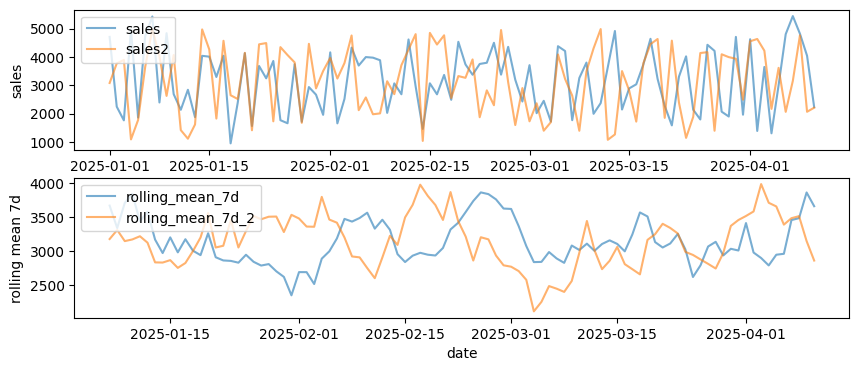

In [79]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(10,4))

ax1 = ax[0]
y = ts_data['sales']
y2 = ts_data['sales2']
x = ts_data['date']
ax1.plot(x,y,alpha=0.6, label='sales')
ax1.plot(x,y2,alpha=0.6, label = 'sales2') # comparison plot with sales2 which is only from random normal distribution
ax1.set_ylabel('sales')
ax1.set_xlabel('date')
ax1.legend(loc='upper left')

ax2 = ax[1]
y = ts_data['rolling_mean_7d']
y2= ts_data['rolling_mean_7d_2']
ax2.plot(x,y, alpha=0.6, label='rolling_mean_7d')
ax2.plot(x,y2, alpha=0.6, label='rolling_mean_7d_2')
ax2.set_ylabel('rolling mean 7d')
ax2.set_xlabel('date')
ax2.legend(loc='upper left')

plt.show()

### Exercise 3 — Time Series Analysis (hard)

**Exercise 3 — Time Series Analysis (hard)**  
Find the best and worst performing days of the week, and calculate week-over-week growth.


In [82]:
# Your turn
day_performance = ts_data.groupby('day_of_week')['sales'].mean().sort_values(ascending=True)
day_performance

day_of_week
Friday       2458.332366
Sunday       2949.518014
Saturday     3053.898029
Tuesday      3257.083677
Monday       3262.806965
Thursday     3445.208489
Wednesday    3736.753750
Name: sales, dtype: float64

In [84]:
print(f"Best day of the week: {day_performance.idxmax()}.")
print(f"Worst day of the week: {day_performance.idxmin()}.")

Best day of the week: Wednesday.
Worst day of the week: Friday.


In [89]:
weekly_sales = ts_data.groupby('week')['sales'].sum().reset_index()
weekly_sales['week_on_week_growth_%']= round(weekly_sales['sales'].pct_change() * 100,2)
weekly_sales

,week,sales,week_on_week_growth_%
0,1,15540.789206,NaN
1,2,25071.176228,61.32
2,3,20598.000000,-17.84
3,4,19910.823772,-3.34
4,5,18842.534961,-5.37
...,...,...,...
10,11,20991.591114,-2.77
11,12,22788.669834,8.56
12,13,21253.103784,-6.74
13,14,20736.846062,-2.43


In [99]:
# test with manual computation
weekly_sales['sales_shift']=weekly_sales['sales'].shift(1)
weekly_sales['weekly_delta']= weekly_sales['sales']-weekly_sales['sales_shift']
weekly_sales['percent_computed']=round(weekly_sales['weekly_delta']/weekly_sales['sales_shift']*100,2)
weekly_sales

,week,sales,week_on_week_growth_%,sales_shift,weekly_delta,percent_computes,percent_computed
0,1,15540.789206,NaN,NaN,NaN,NaN,NaN
1,2,25071.176228,61.32,15540.789206,9530.387022,61.32,61.32
2,3,20598.000000,-17.84,25071.176228,-4473.176228,-17.84,-17.84
3,4,19910.823772,-3.34,20598.000000,-687.176228,-3.34,-3.34
4,5,18842.534961,-5.37,19910.823772,-1068.288811,-5.37,-5.37
...,...,...,...,...,...,...,...
10,11,20991.591114,-2.77,21589.591114,-598.000000,-2.77,-2.77
11,12,22788.669834,8.56,20991.591114,1797.078721,8.56,8.56
12,13,21253.103784,-6.74,22788.669834,-1535.566050,-6.74,-6.74
13,14,20736.846062,-2.43,21253.103784,-516.257722,-2.43,-2.43


<details>
<summary><b>Solution</b></summary>

```python
# Best/worst days
day_performance = ts_data.groupby('day_of_week')['sales'].agg(['mean', 'std'])
day_performance = day_performance.sort_values('mean', ascending=False)
print("Day of week performance:")
print(day_performance)
print(f"\nBest day: {day_performance.index[0]}")
print(f"Worst day: {day_performance.index[-1]}")

# Week-over-week growth
weekly_sales = ts_data.groupby('week')['sales'].sum().reset_index()
weekly_sales['wow_growth'] = weekly_sales['sales'].pct_change() * 100
print("\nWeek-over-week growth:")
print(weekly_sales.head(10))
```
</details>

## 8. Mini-Challenges
- **M1 (easy):** Create a function to detect duplicate rows based on subset of columns
- **M2 (medium):** Implement a data validation function that checks data types and ranges
- **M3 (hard):** Create a pipeline that cleans, transforms, and aggregates raw sales data

In [104]:
# Your turn - try the challenges!

In [117]:
# Create sample CSV data (simulating a file with duplicated rows)
csv_data_duplicated = """order_id,customer_name,product,quantity,price,order_date
1001,Alice Smith,Laptop,1,1200.00,2025-08-15
1002,Bob Jones,Mouse,2,25.50,2025-08-15
1003,Charlie Brown,,1,80.00,2025-08-16
1001,Alice Smith,,1,1200.00,2025-08-15
1005,Diana Prince,Keyboard,3,75.00,2025-08-17
1002,Bob Jones,Mouse,2,,2025-08-15
1003,Charlie Brown,,1,80.00,2025-08-16
1007,Bob Jones,Laptop,1,1200,2025-08-18"""

# Save to file and read back
with open('orders_duplicated.csv', 'w') as f:
    f.write(csv_data_duplicated)

# Read CSV with proper data types
orders_duplicated_df = pd.read_csv('orders_duplicated.csv', parse_dates=['order_date'])

In [3]:
orders_duplicated_df

,order_id,customer_name,product,quantity,price,order_date
0,1001,Alice Smith,Laptop,1,1200.0,2025-08-15
1,1002,Bob Jones,Mouse,2,25.5,2025-08-15
2,1003,Charlie Brown,NaN,1,80.0,2025-08-16
3,1001,Alice Smith,NaN,1,1200.0,2025-08-15
4,1005,Diana Prince,Keyboard,3,75.0,2025-08-17
5,1002,Bob Jones,Mouse,2,NaN,2025-08-15
6,1003,Charlie Brown,NaN,1,80.0,2025-08-16
7,1007,Bob Jones,Laptop,1,1200.0,2025-08-18


In [10]:
orders_duplicated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       8 non-null      int64         
 1   customer_name  8 non-null      object        
 2   product        5 non-null      object        
 3   quantity       8 non-null      int64         
 4   price          7 non-null      float64       
 5   order_date     8 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 516.0+ bytes


### M1 (easy): Create a function to detect duplicate rows based on subset of columns

In [4]:
def find_duplicates(df, subset=None):
    duplicated_rows = df[df.duplicated(subset, keep=False)]
    if subset: return duplicated_rows.sort_values(subset)
    else: return duplicated_rows.sort_values(df.columns.tolist())

In [5]:
print(find_duplicates(orders_duplicated_df))

   order_id  customer_name product  quantity  price order_date
2      1003  Charlie Brown     NaN         1   80.0 2025-08-16
6      1003  Charlie Brown     NaN         1   80.0 2025-08-16


In [6]:
print(find_duplicates(orders_duplicated_df, subset='order_id'))

   order_id  customer_name product  quantity   price order_date
0      1001    Alice Smith  Laptop         1  1200.0 2025-08-15
3      1001    Alice Smith     NaN         1  1200.0 2025-08-15
1      1002      Bob Jones   Mouse         2    25.5 2025-08-15
5      1002      Bob Jones   Mouse         2     NaN 2025-08-15
2      1003  Charlie Brown     NaN         1    80.0 2025-08-16
6      1003  Charlie Brown     NaN         1    80.0 2025-08-16


In [7]:
print(find_duplicates(orders_duplicated_df, subset=['order_id','product']))

   order_id  customer_name product  quantity  price order_date
1      1002      Bob Jones   Mouse         2   25.5 2025-08-15
5      1002      Bob Jones   Mouse         2    NaN 2025-08-15
2      1003  Charlie Brown     NaN         1   80.0 2025-08-16
6      1003  Charlie Brown     NaN         1   80.0 2025-08-16


### M2 (medium): Implement a data validation function that checks data types and ranges

In [85]:
# rules:
rules = {
    'payment' : {
        'type': str,
        'required' : True
    },
    'order_id' : {
        'type' : str,
        'required': True
    },
    'price' : {
        'type' : float,
        'min' : 50.00,
        'required' : True
    }
}

In [86]:
# manual workflow for testing

issues = []
for col, rule in rules.items():
    if col not in orders_duplicated_df.columns and rule.get('required'):
        issues.append(f"Missing required column: {col}")
        continue
    if 'type' in rule:
        wrong_type = orders_duplicated_df[col].apply(lambda x: not isinstance(x, rule['type']))
        if wrong_type.any():
            issues.append(f"{col}: {wrong_type.sum()} type mismatches")
    if 'min' in rule:
        orders_duplicated_df[col] = pd.to_numeric(orders_duplicated_df[col], errors='coerce')  
        below_min = (orders_duplicated_df[col] < rule['min'])|(orders_duplicated_df[col].isna())
        if below_min.any():
            issues.append(f"{col}: {below_min.sum()} values below {rule['min']}")

issues

['Missing required column: payment',
 'order_id: 8 type mismatches',
 'price: 2 values below 50.0']

In [87]:
# define function
def validate_data(df, rules):
    """
    rules = {
        'column_name': {'type': str, 'min': 0, 'max': 100, 'required': True} # do not include min & max for string type
    }
    """
    issues = []
    for col, rule in rules.items():
        if col not in df.columns and rule.get('required'):
            issues.append(f"Missing required column: {col}")
            continue
        if 'type' in rule:
            wrong_type = df[col].apply(lambda x: not isinstance(x, rule['type']))
            if wrong_type.any():
                issues.append(f"{col}: {wrong_type.sum()} type mismatches")
        if 'min' in rule:
            df[col] = pd.to_numeric(df[col], errors='coerce')  
            below_min = (df[col] < rule['min'])|(df[col].isna()) # assuring NaN rows are counted as < min
            if below_min.any():
                issues.append(f"{col}: {below_min.sum()} values below {rule['min']}")

    return issues        

In [88]:
print(validate_data(orders_duplicated_df,rules))

['Missing required column: payment', 'order_id: 8 type mismatches', 'price: 2 values below 50.0']


### M3 (hard): Create a pipeline that cleans, transforms, and aggregates raw sales data

In [89]:
orders_duplicated_df

,order_id,customer_name,product,quantity,price,order_date
0,1001,Alice Smith,Laptop,1,1200.0,2025-08-15
1,1002,Bob Jones,Mouse,2,25.5,2025-08-15
2,1003,Charlie Brown,NaN,1,80.0,2025-08-16
3,1001,Alice Smith,NaN,1,1200.0,2025-08-15
4,1005,Diana Prince,Keyboard,3,75.0,2025-08-17
5,1002,Bob Jones,Mouse,2,NaN,2025-08-15
6,1003,Charlie Brown,NaN,1,80.0,2025-08-16
7,1007,Bob Jones,Laptop,1,1200.0,2025-08-18


In [90]:
orders_duplicated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       8 non-null      int64         
 1   customer_name  8 non-null      object        
 2   product        5 non-null      object        
 3   quantity       8 non-null      int64         
 4   price          7 non-null      float64       
 5   order_date     8 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 516.0+ bytes


In [91]:
print(find_duplicates(orders_duplicated_df, subset='order_id'))

   order_id  customer_name product  quantity   price order_date
0      1001    Alice Smith  Laptop         1  1200.0 2025-08-15
3      1001    Alice Smith     NaN         1  1200.0 2025-08-15
1      1002      Bob Jones   Mouse         2    25.5 2025-08-15
5      1002      Bob Jones   Mouse         2     NaN 2025-08-15
2      1003  Charlie Brown     NaN         1    80.0 2025-08-16
6      1003  Charlie Brown     NaN         1    80.0 2025-08-16


In [106]:
# find numeric rows with null values
copy_orders_duplicated_df=orders_duplicated_df.copy()
numeric_col = copy_orders_duplicated_df.select_dtypes(include='number').columns
null_rows=copy_orders_duplicated_df[numeric_col].isnull().any(axis=1)
rows_to_impute = copy_orders_duplicated_df.index[null_rows]
rows_to_impute

# impute with zero
copy_orders_duplicated_df.loc[rows_to_impute,numeric_col] = copy_orders_duplicated_df.loc[rows_to_impute,numeric_col].apply(pd.to_numeric, errors = 'coerce').fillna(0)
copy_orders_duplicated_df

,order_id,customer_name,product,quantity,price,order_date
0,1001,Alice Smith,Laptop,1,1200.0,2025-08-15
1,1002,Bob Jones,Mouse,2,25.5,2025-08-15
2,1003,Charlie Brown,NaN,1,80.0,2025-08-16
3,1001,Alice Smith,NaN,1,1200.0,2025-08-15
4,1005,Diana Prince,Keyboard,3,75.0,2025-08-17
5,1002,Bob Jones,Mouse,2,0.0,2025-08-15
6,1003,Charlie Brown,NaN,1,80.0,2025-08-16
7,1007,Bob Jones,Laptop,1,1200.0,2025-08-18


In [113]:
copy_df = orders_duplicated_df.copy()
# remove duplicated rows
rows_to_drop = [3,5,6]
copy_df = copy_df.drop(index = rows_to_drop, errors='ignore')

# find null values only for numeric columns
numeric_col = copy_df.select_dtypes(include = 'number').columns
null_rows=copy_df[numeric_col].isnull().any(axis=1)
rows_to_impute = copy_df.index[null_rows]
rows_to_impute

# impute with zero
copy_df.loc[rows_to_impute,numeric_col] = copy_df.loc[rows_to_impute,numeric_col].apply(pd.to_numeric, errors = 'coerce').fillna(0)

# transform - extract the month
copy_df['month']=copy_df['order_date'].dt.to_period('M')

# transform - compute & categorize revenue
copy_df['revenue']=copy_df['quantity']*copy_df['price']
copy_df['revenue_category']= pd.cut(
    copy_df['revenue'],
    bins = [0,500,1000, float('inf')],
    labels = ['Low', 'Medium', 'High']
)

# aggregate
summary = copy_df.groupby(['month','product']).agg({
    'revenue': ['sum','mean','count'],
    'quantity': 'sum'
}).round(2)
print(copy_df)
print(summary)

   order_id  customer_name   product  quantity   price order_date    month  \
0      1001    Alice Smith    Laptop         1  1200.0 2025-08-15  2025-08   
1      1002      Bob Jones     Mouse         2    25.5 2025-08-15  2025-08   
2      1003  Charlie Brown       NaN         1    80.0 2025-08-16  2025-08   
4      1005   Diana Prince  Keyboard         3    75.0 2025-08-17  2025-08   
7      1007      Bob Jones    Laptop         1  1200.0 2025-08-18  2025-08   

   revenue revenue_category  
0   1200.0             High  
1     51.0              Low  
2     80.0              Low  
4    225.0              Low  
7   1200.0             High  
                 revenue               quantity
                     sum    mean count      sum
month   product                                
2025-08 Keyboard   225.0   225.0     1        3
        Laptop    2400.0  1200.0     2        2
        Mouse       51.0    51.0     1        2


In [116]:
def data_pipeline(raw_df, duplicated_rows_to_drop):
    df = raw_df.copy()

    # drop duplicated rows
    df = df.drop(index = duplicated_rows_to_drop, errors='ignore')

    # find numerical columns with null values
    numeric_col = df.select_dtypes(include='number').columns
    null_rows=df[numeric_col].isnull().any(axis=1)
    rows_to_impute = df.index[null_rows]
    
    # impute those numerical columns with zero
    df.loc[rows_to_impute,numeric_col] = df.loc[rows_to_impute,numeric_col].apply(pd.to_numeric, errors = 'coerce').fillna(0)

    # transform - extract the month
    df['month']=df['order_date'].dt.to_period('M')

    # transform - compute & categorize revenue
    df['revenue']=df['quantity']*df['price']
    df['revenue_category']= pd.cut(
        df['revenue'],
        bins = [0,500,1000, float('inf')],
        labels = ['Low', 'Medium', 'High']
    )

    # aggregate
    summary = df.groupby(['month','product']).agg({
        'revenue': ['sum','mean','count'],
        'quantity': 'sum'
    }).round(2)

    print("Modified data frame:")
    print(df)
    print("\nSummary by month and product:")
    print(summary) 
    

In [118]:
print(data_pipeline(orders_duplicated_df, rows_to_drop))

Modified data frame:
   order_id  customer_name   product  quantity   price order_date    month  \
0      1001    Alice Smith    Laptop         1  1200.0 2025-08-15  2025-08   
1      1002      Bob Jones     Mouse         2    25.5 2025-08-15  2025-08   
2      1003  Charlie Brown       NaN         1    80.0 2025-08-16  2025-08   
4      1005   Diana Prince  Keyboard         3    75.0 2025-08-17  2025-08   
7      1007      Bob Jones    Laptop         1  1200.0 2025-08-18  2025-08   

   revenue revenue_category  
0   1200.0             High  
1     51.0              Low  
2     80.0              Low  
4    225.0              Low  
7   1200.0             High  

Summary by month and product:
                 revenue               quantity
                     sum    mean count      sum
month   product                                
2025-08 Keyboard   225.0   225.0     1        3
        Laptop    2400.0  1200.0     2        2
        Mouse       51.0    51.0     1        2
None


<details>
<summary><b>Solutions</b></summary>

```python
# M1 - Duplicate detection
def find_duplicates(df, subset=None):
    duplicates = df[df.duplicated(subset=subset, keep=False)]
    return duplicates.sort_values(subset if subset else df.columns.tolist())

# M2 - Data validation
def validate_data(df, rules):
    """
    rules = {
        'column_name': {'type': str, 'min': 0, 'max': 100, 'required': True}
    }
    """
    issues = []
    for col, rule in rules.items():
        if col not in df.columns and rule.get('required'):
            issues.append(f"Missing required column: {col}")
            continue
        
        if 'type' in rule:
            wrong_type = df[col].apply(lambda x: not isinstance(x, rule['type']))
            if wrong_type.any():
                issues.append(f"{col}: {wrong_type.sum()} type mismatches")
        
        if 'min' in rule:
            below_min = df[col] < rule['min']
            if below_min.any():
                issues.append(f"{col}: {below_min.sum()} values below {rule['min']}")
    
    return issues

# M3 - Data pipeline
def sales_pipeline(raw_df):
    # Clean
    df = raw_df.copy()
    df = df.dropna(subset=['product', 'revenue'])
    df['date'] = pd.to_datetime(df['date'])
    
    # Transform
    df['month'] = df['date'].dt.to_period('M')
    df['revenue_category'] = pd.cut(df['revenue'], 
                                     bins=[0, 500, 1000, float('inf')],
                                     labels=['Low', 'Medium', 'High'])
    
    # Aggregate
    summary = df.groupby(['month', 'product']).agg({
        'revenue': ['sum', 'mean', 'count'],
        'quantity': 'sum'
    }).round(2)
    
    return summary

# Test pipeline
result = sales_pipeline(sales)
print("Pipeline output:")
print(result.head())
```
</details>

## Wrap-Up
✅ You can read and clean messy real-world data  
✅ You mastered merging, grouping, and pivoting  
✅ You can handle dates, strings, and missing values  

**Next:** EDA - Exploring and understanding your cleaned data!
